In [71]:
%load_ext autoreload
%autoreload 2

from hyper_qa.model import HyperQA
from hyper_qa.utilities import riemannian_gradient, get_loss
import numpy as np
import tensorflow as tf
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

tf.enable_eager_execution()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
tf.random.set_random_seed(212)

array([219, 516, 587, 327,  45,  53,  35, 240, 141, 283, 954, 605, 122,
       377, 624, 786, 403,  27, 856, 102, 259, 998])

In [73]:
embedding_matrix = np.random.normal(0, 1, (1000, 300))
def generate_samples(max_length, sample_size, vocab_size=1000, pad=False):
    lengths = []
    sample_sequences = []
    for i in range(sample_size):
        text = np.random.randint(1,1000, np.random.randint(1,max_length))
#         text = np.arange(i%max_length)
        if pad:
            sample = np.concatenate((text, [0] * (max_length - len(text))))
        else:
            sample = text
        lengths.append(len(text))
        sample_sequences.append(sample)
    if pad:
        sample_sequences = np.vstack(sample_sequences)
    return sample_sequences

In [142]:
max_length = 50
q = generate_samples(max_length, 200, pad=True)
a = generate_samples(max_length, 200, pad=True)
b = generate_samples(max_length, 200, pad=True)

dataset = tf.data.Dataset.from_tensor_slices((q, a, b))
dataset = dataset.shuffle(200).repeat(count=5).batch(5)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)


In [143]:
data_iter = dataset.make_one_shot_iterator()
model = HyperQA(1000, max_length, embedding_matrix=embedding_matrix)

margin = tf.constant(5.0)
loss_history = []
steps = 500
for q1, q2, q3 in data_iter:
    with tf.GradientTape() as tape:
        sim_pos, sim_neg = model((q,a,b), training=True)
        loss = get_loss((sim_pos, sim_neg), margin)
        loss_history.append(loss.numpy())
    
    gradients = tape.gradient(loss, model.trainable_variables)
    riem_gradients = [gradients[0]] + [riemannian_gradient(grad) for grad in gradients[1:]]
    clipped_gradients = [riem_gradients[0]] + [tf.clip_by_norm(grad, 1.0) for grad in riem_gradients[1:]]
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
    

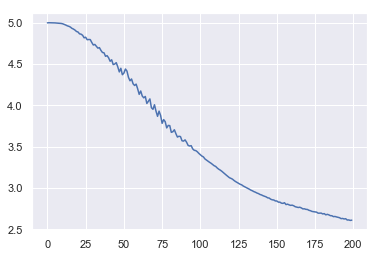

In [141]:
plt.plot(loss_history)

In [108]:
a = np.random.randint(1,1000, size=(1,50))
b = np.random.randint(1,234, size=(1,50))

prediction = model((a, b))

In [110]:
prediction.numpy()

array([-20.552065, -20.299938, -20.122303, -20.439898, -20.607527],
      dtype=float32)